## 读取数据

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

data_frame=pd.read_csv('../data/test_data1_3type.csv', 
                       names=['category', 'text'],
                       index_col=False
                       )

In [2]:
possible_categories=data_frame.category.unique()
possible_categories

array([1, 3, 5], dtype=int64)

In [3]:
# 标签映射
label_dict={}
for index, possible_category in enumerate(possible_categories):
    label_dict[possible_category]=index
label_dict

{1: 0, 3: 1, 5: 2}

In [4]:
data_frame['label']=data_frame.category.replace(label_dict)
data_frame.head(10)

,category,text,label
0,1,还好吧，不喜欢里面的中国元素。,0
1,1,名气很高，但真实情况是？失望！,0
2,1,不喜欢阿三,0
3,1,我还以为英国的电影呢我是看一群帅哥的面才看完这部电影的。电影的故事不外乎成人世界压抑天性，正...,0
4,1,讲真，美国真是好人多，中国真是坏人多，这种人在中国太多了，估计一大堆做假的各种领导学者在中国...,0
5,1,这部电影对于我个人非常有纪念意义，它令我惊觉自己的改变。那种宁愿守着旧梦死去也不愿意走向迷茫...,0
6,1,就是个小时长的日剧嘛。拉大提琴的几场尤其造作尤其傻，这种半调子剧本、台词、烂表演、配这种业余...,0
7,1,很低俗，猥琐，，，周星驰就爱这个是吧，我几乎要放弃看他的作品了。只有黄圣依美是真美，但目的呢...,0
8,1,就靠各类动物的体型差和一路不停的耍宝来制造萌点吧。食肉动物的本性本来就是野蛮：树獭一点也不好...,0
9,1,昏昏欲睡。以为会对自己的刑法理论有一定的冲击，但失望了，讲的不就是罪刑法定原则吗？需要拍的那...,0


In [5]:
selected_col=['text','label']
sub_df=data_frame[selected_col]
sub_df=sub_df.sample(frac=0.3)
sub_df

,text,label
324,不知道是剧情不好 还是我不喜欢这风格 勉强看完,0
466,序幕一上来就对农场主奴隶制的逝去时光表达了一波怀旧，真是让人浑身难受，还A civiliza...,0
677,为什么常年位居圣诞电影推荐榜单上啊，剧情又臭又长的,0
1881,杀手不冷，萝莉坚忍，他们的那种爱与不能，细腻、动人、深刻。这种最内敛最纯粹最真挚的情感，融于...,2
881,没有人是逃避着走向人生的终点的。父亲就如同那条大鱼，向往最热切的自由和对生活的企盼，终其一生...,1
...,...,...
1406,这一部一点都不entertaining，父与子在音乐和画面重叠的转场下在时间的波涛中相望。时...,1
1268,影片足以炫耀的东西不够多，但是拍得不错，而且有趣的元素不少，影片更注重对白而不是紧凑的动作戏。,1
1472,SIFF 重看降一星 吴宇森大概只会拍这种直男魅力片 不过看到最后还是迷之感动,1
942,评分有点虚高，这些jc智商不在线，纯属是搞笑的，尤其一个男的还要和那个女的，开车还掉了还挺讽...,1


In [6]:
# 划分训练集、验证集、测试集 
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(sub_df.index.values, 
                                                    sub_df.label.values,
                                                    test_size = 0.15, 
                                                    random_state=17, 
                                                    stratify = sub_df.label.values)

In [12]:
sub_df['data_type']=['not_set']*sub_df.shape[0]
sub_df.loc[X_train, 'data_type']='train'
sub_df.loc[X_val, 'data_type']='val'
sub_df.groupby(['label', 'data_type']).count()

text
label data_type      
0     train       195
      val          34
1     train       221
      val          39
2     train       196
      val          35

## 分析数据

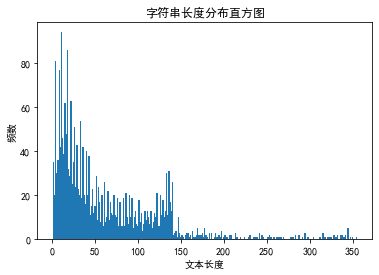

In [13]:
import matplotlib.pyplot as plt
# 设置全局字体为SimHei，这是一种支持中文的字体  
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像时负号'-'显示为方块的问题  
plt.rcParams['axes.unicode_minus'] = False 

# 计算字符串长度并统计分布  
length_counts = data_frame['text'].apply(len).value_counts().sort_index()  

# 绘制直方图  
plt.hist(length_counts.index, bins=len(length_counts), weights=length_counts.values)  
plt.xlabel('文本长度')  
plt.ylabel('频数')  
plt.title('字符串长度分布直方图')  
plt.show()


## 下载预训练模型（代码/手动下载）

## 加载Tokenizer和Encoding the Data

In [15]:
# 下载的预训练文件路径
BERT_PATH = '../Models/bert-base-chinese'

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

# 加载分词器
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)


# 将strings转化为tokens
encoded_data_train = tokenizer.batch_encode_plus(
    sub_df[sub_df.data_type=='train'].text.values,
    add_special_tokens=True,    # This is just the BERT way of knowing that when the sentence ends and when the a new one begins.
    return_attention_mask=True, # 为将不同长度的句子拥有相同的维度，将max_length设置为很大的数字256，
    pad_to_max_length=True,      # attention_mask表示实际值在哪里，同时哪里为空值
    max_length=256,
    return_tensors='pt' # pt表示PyTorch
    )
encoded_data_val= tokenizer.batch_encode_plus(
    sub_df[sub_df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
    )

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(sub_df[sub_df.data_type=='train'].label.values)
input_ids_val = encoded_data_val['input_ids']   # input_ids用数字表示每个word
attention_masks_val= encoded_data_val['attention_mask']
labels_val = torch.tensor(sub_df[sub_df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print("len(dataset_train):", len(dataset_train))
print("len(dataset_val):", len(dataset_val))



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


len(dataset_train): 612
len(dataset_val): 108


## 加载预训练模型

In [21]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    BERT_PATH, 
    num_labels = len(label_dict), 
    output_attentions=False,    # 是否输出注意力分散
    output_hidden_states=False  # 是否输出模型的隐藏状态
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../Models/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 创建DataLoader

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
dataloader_val = DataLoader(dataset_val,
                            sampler=RandomSampler(dataset_val),
                            batch_size=batch_size)

## 创建Optimizer and Scheduler

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                lr=1e-5, #2e-5 > 5e-5 
                eps=1e-8)

epochs=5
# 线性学习率调度器，在训练的后续阶段线性下降
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

c:\Users\DHW\.conda\envs\d2l\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Define the Performance Metrics

In [25]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')



In [27]:
import random

seed_val = 8
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

cuda


## 训练模型

In [28]:
import os
# 本地保存的模型参数路径
save_path = "./bert_checkpoint"
epoch_trained = 0  # 已保存的模型的epoch

# 保存模型权重
def save_model(epoch):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_name=f"bert-base-chinese_epoch_{epoch}.model"
    torch.save(model.state_dict(), os.path.join(save_path, save_name))

# 从本地加载已经训练过的模型参数
# model.load_state_dict(torch.load(f'{save_model}/bert-base-chinese_epoch_{epoch_trained}.model'))

In [29]:
for epoch in tqdm(range(epoch_trained+1, epoch_trained+1+epochs)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar =  tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),leave=False,disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
            
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch))})

    save_model(epoch=epoch) 
    # torch.save(model.state_dict(), f'Models/BERT_ft_epoch_{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1330736478169758
Validation loss: 1.0584240896361214
F1 Score (weighted): 0.3174341849205237


Epoch 2:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0097618362842462
Validation loss: 0.9864071352141244
F1 Score (weighted): 0.5675936067502333


Epoch 3:   0%|          | 0/39 [00:00<?, ?it/s]

## Evaluate our Model

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals )